In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

In [29]:
# Extract data
route = 20
station = 19
data = pd.read_csv("Data/Cleaned_data.csv")
y = data[(data['visualiseringskode'] == route) & (data['station'] == station)]['togpunktlighed'].values
X = data[(data['visualiseringskode'] == route) & (data['station'] == station)].iloc[:,2:]

# Shift
#y = y[4:]
#X = X.iloc[:-4, :]
#print(y.shape, X.shape)

# Uncertainty quantification

### Get correct data and train models

In [30]:
# ACROSS different time slots. WHAT ABOUT ACROSS DIFFERENT route/station pairs but always the most recent time slot - unrealistic setting does not tell us much. 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Number of models to train in the ensemble
num_models = 18

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Calculate chunk size and overlap
chunk_size = 400  # Ensure overlap
overlap = int(chunk_size * 1/4) # 100 jump every time. meaning shares 3/4 training data

print(chunk_size, overlap)
# Generate overlapping data chunks
train_chunks_X = [X_train[i:i+chunk_size] for i in range(0, len(X_train) - chunk_size + 1, overlap)]
train_chunks_y = [y_train[i:i+chunk_size] for i in range(0, len(y_train) - chunk_size + 1, overlap)]
print(len(train_chunks_X))
# Ensure last chunk reaches the end of the dataset
if len(train_chunks_X[-1]) < chunk_size:
    print('Hi')
    train_chunks_X[-1] = X_train[-chunk_size:]
    train_chunks_y[-1] = y_train[-chunk_size:]

# Train ensemble of XGBoost models
models = []
for i in range(num_models):
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
    model = boosted_model.fit(train_chunks_X[i], train_chunks_y[i])
    models.append(model)


400 100
18


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:49] WARNING: /Users/runner/work

### Prediction and plot functions

In [31]:
# Predictions
def predict_with_uncertainty_conf_int(models, X_test, y_test, conf_int=90):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    
    # True uncertainty
    consensus_predictions = np.mean(predictions, axis = 1)
    true_uncertainty = np.abs(consensus_predictions - y_test) # True absolute error

    # Conf interval and min/max
    sorted_predictions = np.sort(predictions, axis=1)
    diff = int(((100 - conf_int) / 2 / 100) * predictions.shape[1])
    start_index = diff
    end_index = predictions.shape[1] - diff
    print(sorted_predictions[:, start_index:end_index].shape)
    estimated_uncertainty = sorted_predictions[:, end_index] - sorted_predictions[:, start_index] # Calculated as difference between max and min in x% conf interval. x = conf_int. for STD = 68%
    
    return true_uncertainty, estimated_uncertainty, consensus_predictions

def fischer_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.log((1 + correlations) / (1 - correlations))
    return transformed_std_devs

def arctangent_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.arctan(correlations)
    return transformed_std_devs

def predict_with_uncertainty_std(models, X_test, y_test, transform = 'fischer'):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    
    # True uncertainty
    consensus_predictions = np.mean(predictions, axis = 1)
    true_uncertainty = np.abs(consensus_predictions - y_test) # True absolute error

    # Uncertainty estimate via std
    estimated_uncertainty = np.std(predictions, axis=1)
    if transform == 'fischer':
        transformed_uncertainty = fischer_transformation(estimated_uncertainty)
    elif transform == 'argtan':
        transformed_uncertainty = arctangent_transformation(estimated_uncertainty)
    return true_uncertainty, transformed_uncertainty, consensus_predictions

In [32]:
# Plot mean predictions with uncertainty in time series format
from sklearn.linear_model import LinearRegression

def time_series_uncertainty(mean_pred, y_test, estimated_uncertainty):
    plt.plot(range(len(mean_pred[-30:])), y_test[-30:], label='True Value')
    plt.errorbar(range(len(mean_pred[-30:])), mean_pred[-30:], yerr=estimated_uncertainty[-30:], fmt='o', capsize=5, label='Predictions with estimated uncertainty')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.ylim(0, 1)
    plt.title('Mean Predictions with Uncertainty')
    plt.legend()
    plt.grid()
    plt.show()

def histogram_uncertainty(true_uncertainty, estimated_uncertainty):
    plt.hist(true_uncertainty, label = 'True uncertainty')
    plt.hist(estimated_uncertainty,  label = 'Estimated uncertainty')
    plt.title('Uncertainty quantification')
    plt.legend()
    plt.grid()
    plt.show()

def correlation_scatter(true_uncertainty, estimated_uncertainty):
    plt.scatter(estimated_uncertainty, true_uncertainty)
    plt.xlabel('Estimated Uncertainty')
    plt.ylabel('True Uncertainty')
    plt.title('Correlation Plot: Uncertainty Quantification')
    # Fit a line to correct the estimated uncertainty
    model = LinearRegression()
    model.fit(np.array(estimated_uncertainty).reshape(-1, 1), true_uncertainty)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot(np.array(estimated_uncertainty), slope*np.array(estimated_uncertainty) + intercept, color='red')
    plt.grid()
    plt.show()
    print(f"Regression line: y = {slope:.2f}x + {intercept:.2f}") # Interessant resultat?

In [33]:
true_uncertainty, estimated_uncertainty, consensus_predictions = predict_with_uncertainty_conf_int(models, X_test, y_test, conf_int=68)

difference = np.mean(true_uncertainty) - np.mean(estimated_uncertainty)
print(f'Error variance (true): {np.mean(true_uncertainty)}')
print(f"Mean model's uncertainty (estimate): {np.mean(estimated_uncertainty)}")

print("Difference between error variance and mean model uncertainty:", difference)
# Show values

(365, 14)
Error variance (true): 0.06606273259064196
Mean model's uncertainty (estimate): 0.0874388188531954
Difference between error variance and mean model uncertainty: -0.02137608626255344


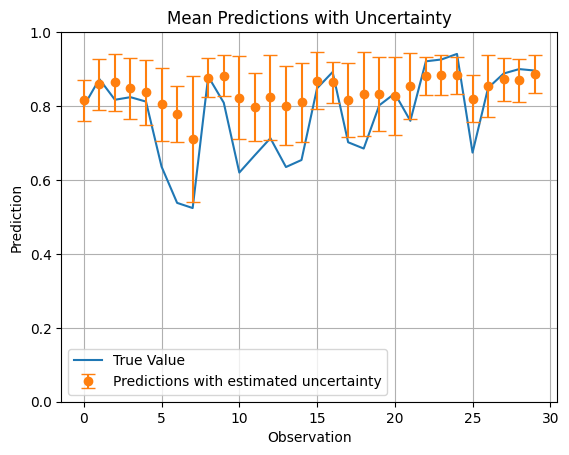

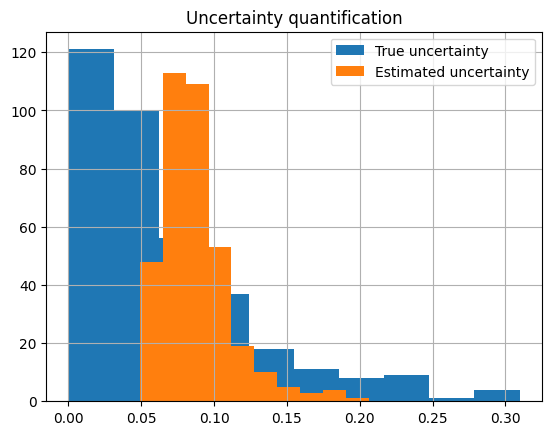

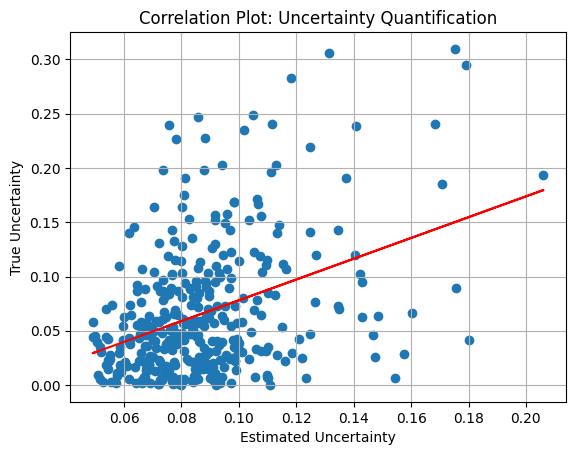

Regression line: y = 0.96x + -0.02


In [34]:
# Plots
time_series_uncertainty(consensus_predictions, y_test, estimated_uncertainty)
histogram_uncertainty(true_uncertainty, estimated_uncertainty)
correlation_scatter(true_uncertainty, estimated_uncertainty)

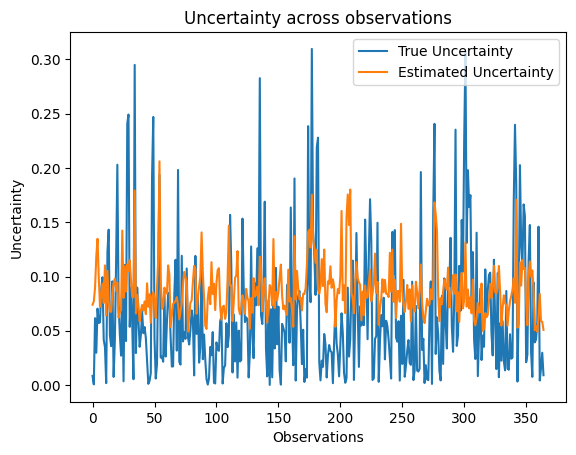

In [35]:
plt.plot(true_uncertainty, label='True Uncertainty') # Prøv true uncertainty - sammenlign med estimated uncertainty.
plt.plot(estimated_uncertainty, label='Estimated Uncertainty') # Prøv true uncertainty - sammenlign med estimated uncertainty.
plt.xlabel('Observations')
plt.ylabel('Uncertainty')
plt.title('Uncertainty across observations')
plt.legend()
plt.show()

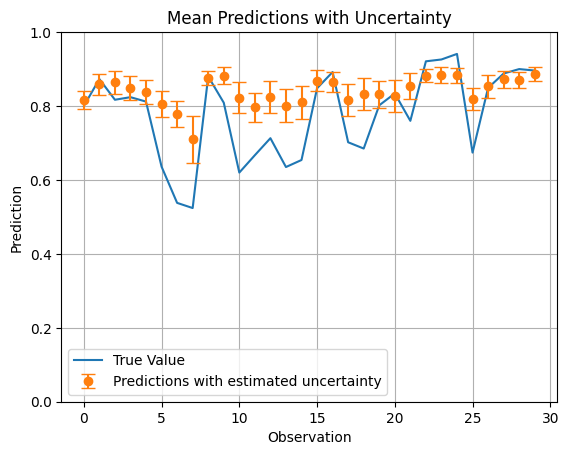

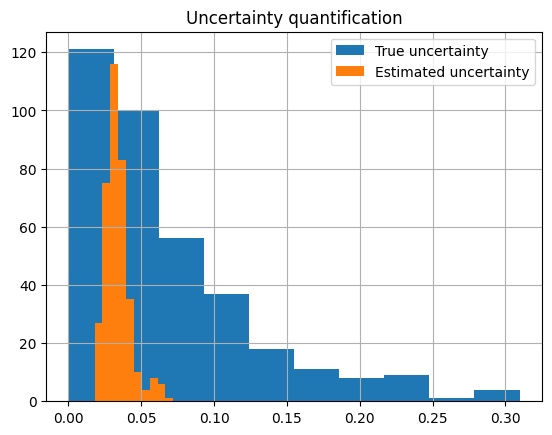

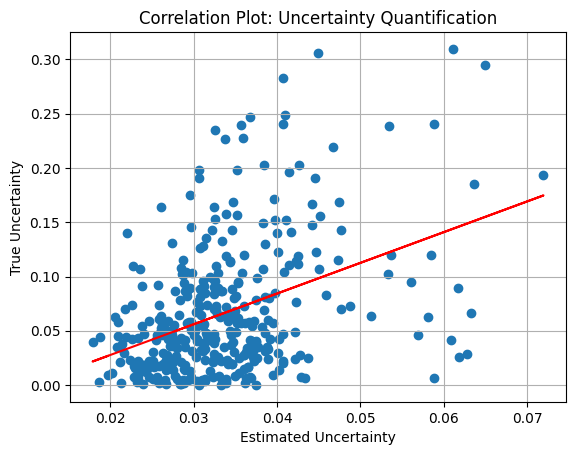

Regression line: y = 2.83x + -0.03


In [36]:
# With std and transformations either 'fischer' or 'argtan'
true_uncertainty, estimated_uncertainty, consensus_predictions = predict_with_uncertainty_std(models, X_test, y_test, transform='fischer')

time_series_uncertainty(consensus_predictions, y_test, estimated_uncertainty)
histogram_uncertainty(true_uncertainty, estimated_uncertainty)
correlation_scatter(true_uncertainty, estimated_uncertainty)

# XGBoost with Simple Idea

In [5]:
# ACROSS different time slots. WHAT ABOUT ACROSS DIFFERENT route/station pairs but always the most recent time slot - unrealistic setting does not tell us much. 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Number of models to train in the ensemble
num_models = 10

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

# Splitting the data into continuous chunks for training
chunk_size = len(X_train) // num_models  # Assuming equal-sized chunks
train_chunks_X = [X_train[i:i+chunk_size] for i in range(0, len(X_train), chunk_size)]
train_chunks_y = [y_train[i:i+chunk_size] for i in range(0, len(y_train), chunk_size)]

# Train ensemble of XGBoost models
models = []
for i in range(num_models):
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
    model = boosted_model.fit(train_chunks_X[i], train_chunks_y[i])
    models.append(model)

# Function to make predictions and estimate uncertainty
def predict_with_uncertainty(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    mean_prediction = np.mean(predictions, axis=1)
    uncertainty = np.std(predictions, axis=1)
    return mean_prediction, uncertainty

# Example usage
mean_pred, uncertainty = predict_with_uncertainty(models, X_test)
print("Mean Predictions:", mean_pred)
print("Uncertainty Estimates:", uncertainty)


/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:04:01] WARNING: /Users/runner/work

Mean Predictions: [0.78800874 0.86321303 0.86692839 0.83564258 0.82155189 0.79964926
 0.75750579 0.71056368 0.878574   0.87985192 0.81362416 0.77743399
 0.81285757 0.79479394 0.81140463 0.8641637  0.87124973 0.80622042
 0.81994921 0.81506035 0.80866545 0.84553658 0.86606776 0.87987108
 0.87313122 0.82256118 0.85528483 0.85869615 0.85774692 0.87330461]
Uncertainty Estimates: [0.05339406 0.02890126 0.03496154 0.0434951  0.04321803 0.05391671
 0.05549691 0.07725299 0.02270478 0.01987097 0.04898058 0.04273711
 0.03838789 0.03529246 0.05067694 0.02669465 0.02301546 0.04377937
 0.04036861 0.03929771 0.04348816 0.03703032 0.03412032 0.02248814
 0.0258294  0.03461146 0.03535825 0.03824491 0.04172818 0.03165444]


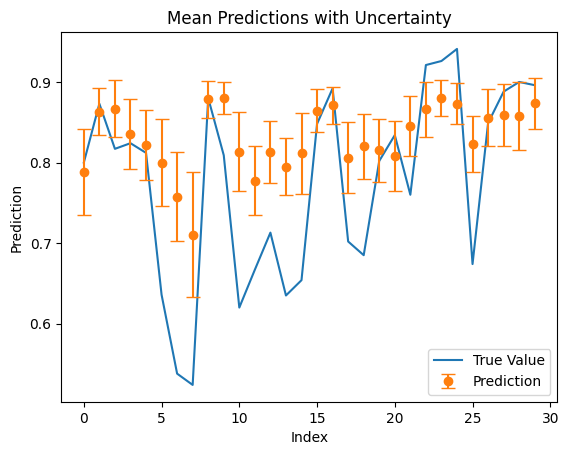

In [6]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred)), y_test, label='True Value')
plt.errorbar(range(len(mean_pred)), mean_pred, yerr=uncertainty, fmt='o', capsize=5, label='Prediction')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.show()

# Catboost with Paper's Idea

In [7]:
def ensemble(train_pool, val_pool, test_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    for seed in range(num_samples):
        model = cb.CatBoostRegressor(iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False, random_seed=seed)
        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(test_pool))
    return np.asarray(ens_preds)

In [8]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=256, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Convert data into a format suitable for CatBoost
train_pool = cb.Pool(data=X_train, label=y_train)
val_pool = cb.Pool(data=X_val, label=y_val)
test_pool = cb.Pool(data=X_test, label=y_test)  # Provide labels for test data

In [9]:
ens_preds = ensemble(train_pool, val_pool, test_pool)

In [10]:
# Shape (models, test_size, estimates)
ens_preds.shape

(10, 256, 2)

In [11]:
# Prediction with uncertainty
ens_preds[0,0]

array([0.72957038, 0.00384718])

In [12]:
import seaborn as sns
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

Average predicted data uncertainty:


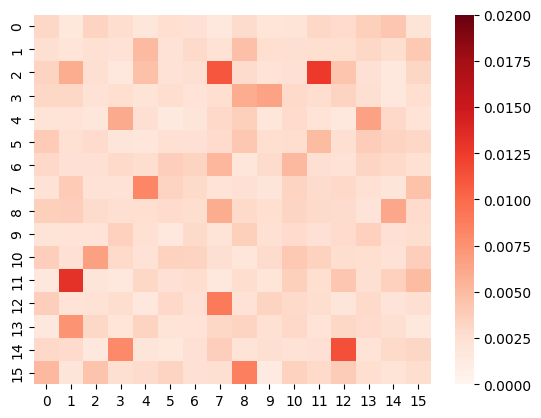

In [13]:
print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([16, 16]), cmap="Reds", vmin=0, vmax=0.02)
plt.savefig("heart_data_sglb.pdf")
plt.show()

Knowledge uncertainty via ensemble:


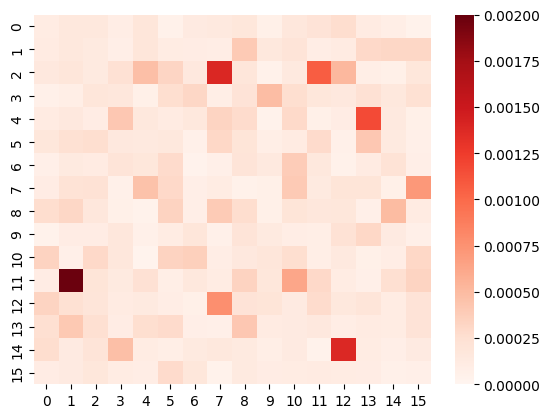

In [14]:
print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([16, 16]), cmap="Reds", vmin=0, vmax=0.002)
plt.savefig("heart_knowledge_sglb.pdf")
plt.show()

For regression, data uncertainty is the average variance predicted by the models, while knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models.

Data uncertainty arises due to the inherent complexity of the data, such as additive noise or overlapping classes. In these cases, the model knows that the input has attributes of multiple classes or that the target is noisy. Importantly, data uncertainty cannot be reduced by collecting more training data.

Knowledge uncertainty coming from the lack of training data in a particular region. If all the models understand an input, they will give similar predictions (low knowledge uncertainty). However, if the models do not understand the input, then they are likely to provide diverse predictions and strongly disagree with each other (high knowledge uncertainty). For regression, knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models.


In [15]:
#sorted_indices = np.argsort(y_test)
#sorted_y_test = y_test[sorted_indices]
#sorted_data_knowledge = (data + knowledge)[sorted_indices]

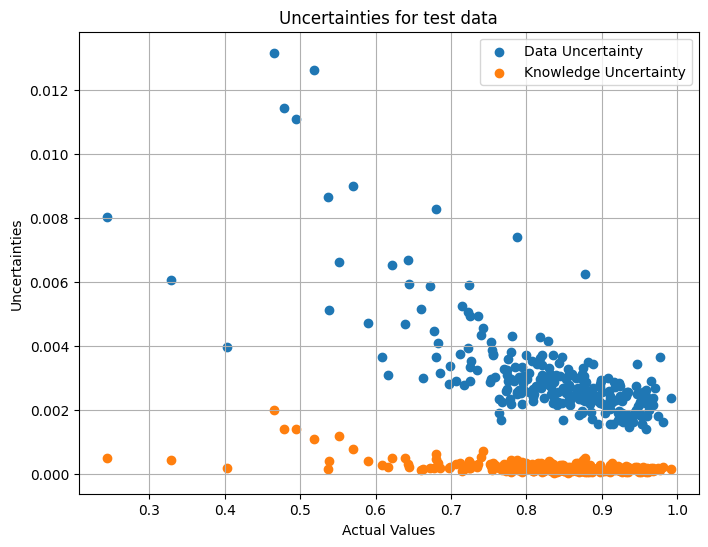

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, data, label='Data Uncertainty')
plt.scatter(y_test, knowledge, label='Knowledge Uncertainty')
#plt.plot(sorted_y_test, sorted_data_knowledge)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Uncertainties')
plt.title('Uncertainties for test data')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost with fischer (incorrect math)

But we need mean_pred for the ones with correct math

In [17]:
def fischer_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.log((1 + correlations) / (1 - correlations))
    return transformed_std_devs

def arctangent_transformation(std_devs):
    correlations = np.tanh(std_devs)
    transformed_std_devs = 0.5 * np.arctan(correlations)
    return transformed_std_devs

In [18]:
# ACROSS different time slots. WHAT ABOUT ACROSS DIFFERENT route/station pairs but always the most recent time slot - unrealistic setting does not tell us much. 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Number of models to train in the ensemble
num_models = 100

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Splitting the data into continuous chunks for training
chunk_size = len(X_train) // num_models  # Assuming equal-sized chunks
train_chunks_X = [X_train[i:i+chunk_size] for i in range(0, len(X_train), chunk_size)]
train_chunks_y = [y_train[i:i+chunk_size] for i in range(0, len(y_train), chunk_size)]

# Train ensemble of XGBoost models
models = []
for i in range(num_models):
    boosted_model = xgb.XGBRegressor(objective = 'reg:absoluteerror', booster='gbtree', steps=20, learning_rate=0.1, max_depth=5) 
    model = boosted_model.fit(train_chunks_X[i], train_chunks_y[i])
    models.append(model)

# Function to make predictions and estimate uncertainty
def predict_with_uncertainty1(models, X_test, transform=''):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    mean_prediction = np.mean(predictions, axis=1)
    uncertainty = np.std(predictions, axis=1)
    if transform == 'fischer':
        transformed_uncertainty = fischer_transformation(uncertainty)
    elif transform == 'argtan':
        transformed_uncertainty = arctangent_transformation(uncertainty)
    return mean_prediction, transformed_uncertainty

# Example usage
mean_pred, transformed_uncertainty = predict_with_uncertainty1(models, X_test, transform='argtan')

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "steps" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:04] WARNING: /Users/runner/work

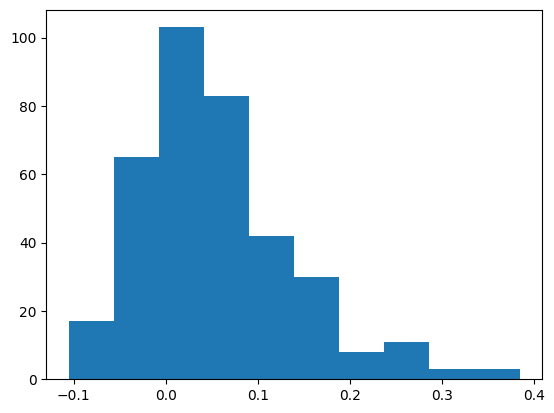

In [19]:
# Histogram for error should be normal distributed
error = mean_pred - y_test
plt.hist(error)
plt.show()

Ikke normaltfordelt. Vi gætter generelt på en højere togpunktlighed end true value

In [20]:
variance_error = np.var(error)
difference = variance_error - np.mean(transformed_uncertainty)
print(f'Error variance (true): {variance_error}')
print(f"Mean model's uncertainty (estimate): {np.mean(transformed_uncertainty)}")

print("Difference between error variance and mean model uncertainty:", difference)
# Show values

Error variance (true): 0.007313051993495423
Mean model's uncertainty (estimate): 0.031428552636990306
Difference between error variance and mean model uncertainty: -0.024115500643494884


De skulle gerne passe. Det er netop variansen i vores fejl vi prøver at estimere gennem uncertainty. 

Den er negativ hvilket betyder at vi overestimere usikkerheden ift. den faktiske variansen af vores faktiske fejl. Det er tilgengæld ikke meget.

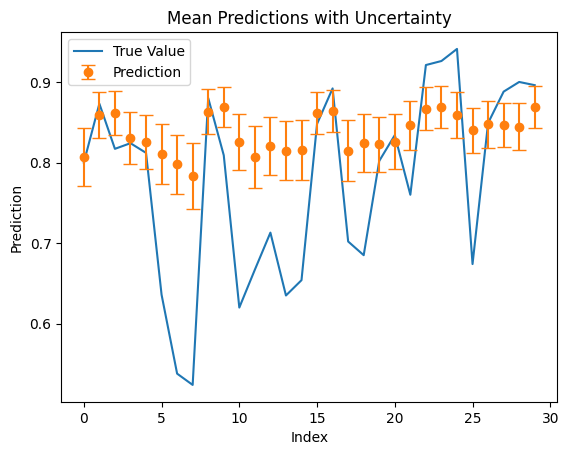

In [21]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred[-30:])), y_test[-30:], label='True Value')
plt.errorbar(range(len(mean_pred[-30:])), mean_pred[-30:], yerr=transformed_uncertainty[-30:], fmt='o', capsize=5, label='Prediction')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.show()

# Std 

In [22]:
# Function to make predictions and estimate uncertainty
def predict_with_uncertainty_std(models, X_test, transform=''):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    # True uncertainty
    true_uncertainty = np.std(predictions - y_test.reshape(365,1), axis=1)

    # Uncertainty estimate via std
    estimated_uncertainty = np.std(predictions, axis=1)
    if transform == 'fischer':
        transformed_uncertainty = fischer_transformation(estimated_uncertainty)
    elif transform == 'argtan':
        transformed_uncertainty = arctangent_transformation(estimated_uncertainty)
    return true_uncertainty, transformed_uncertainty

# Example usage
true_uncertainty, estimated_uncertainty = predict_with_uncertainty_std(models, X_test, transform='argtan')

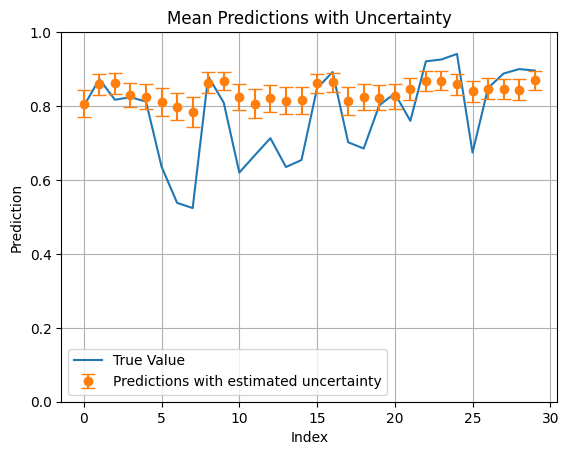

In [23]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred[-30:])), y_test[-30:], label='True Value')
plt.errorbar(range(len(mean_pred[-30:])), mean_pred[-30:], yerr=estimated_uncertainty[-30:], fmt='o', capsize=5, label='Predictions with estimated uncertainty')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.ylim(0, 1)
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.grid()
plt.show()

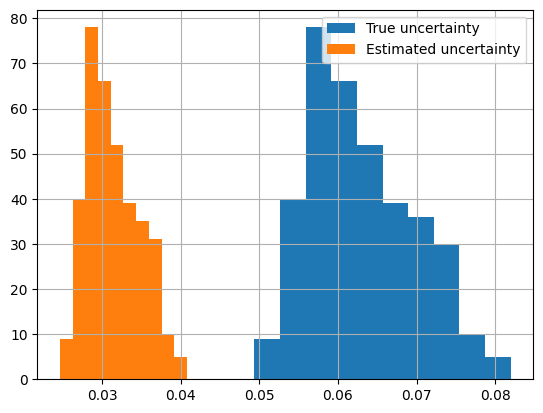

In [24]:
plt.hist(true_uncertainty, label = 'True uncertainty')
plt.hist(estimated_uncertainty,  label = 'Estimated uncertainty')
plt.legend()
plt.grid()
plt.show()

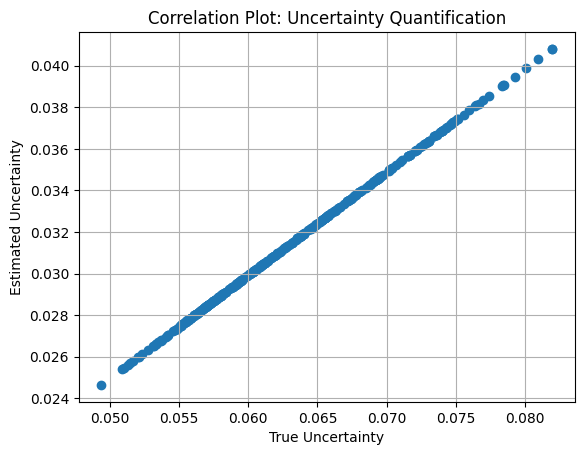

In [25]:
plt.scatter(true_uncertainty, estimated_uncertainty) # same shit bare på to forskellige/ens måder
plt.xlabel('True Uncertainty')
plt.ylabel('Estimated Uncertainty')
plt.title('Correlation Plot: Uncertainty Quantification')
plt.grid()
plt.show()

# Conf int

In [26]:
def predict_with_uncertainty_conf_int(models, X_test, y_test, conf_int=90):
    predictions = np.zeros((X_test.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X_test)
    
    # True uncertainty
    true_uncertainty = np.std(predictions - y_test.reshape(365,1), axis=1)

    # Conf interval and min/max
    sorted_predictions = np.sort(predictions, axis=1)
    diff = (100 - conf_int) / 2
    start_index = int(diff + 1)
    end_index = int(100 - diff + 1)
    print(sorted_predictions[:, start_index:end_index].shape)
    estimated_uncertainty = sorted_predictions[:, end_index] - sorted_predictions[:, start_index] # Calculated as difference between max and min in x% conf interval. x = conf_int. for STD = 68%
    
    return true_uncertainty, estimated_uncertainty
true_uncertainty, estimated_uncertainty = predict_with_uncertainty_conf_int(models, X_test, y_test, conf_int=68)

(365, 68)


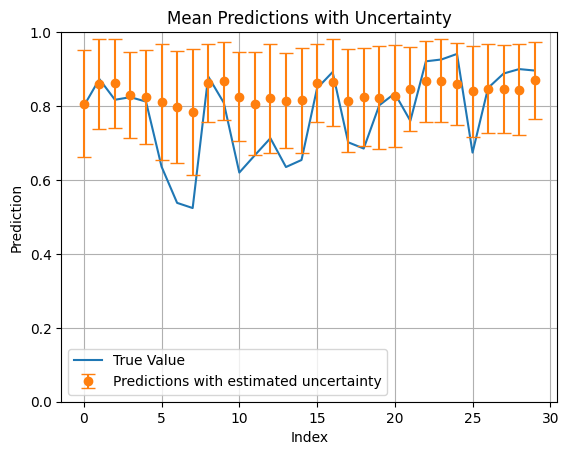

In [27]:
# Plot mean predictions with uncertainty
plt.plot(range(len(mean_pred[-30:])), y_test[-30:], label='True Value')
plt.errorbar(range(len(mean_pred[-30:])), mean_pred[-30:], yerr=estimated_uncertainty[-30:], fmt='o', capsize=5, label='Predictions with estimated uncertainty')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.ylim(0, 1)
plt.title('Mean Predictions with Uncertainty')
plt.legend()
plt.grid()
plt.show()

In [28]:
difference = np.mean(true_uncertainty) - np.mean(estimated_uncertainty)
print(f'Error variance (true): {np.mean(true_uncertainty)}')
print(f"Mean model's uncertainty (estimate): {np.mean(estimated_uncertainty)}")

print("Difference between error variance and mean model uncertainty:", difference)
# Show values

Error variance (true): 0.06302923815929841
Mean model's uncertainty (estimate): 0.1234998588692652
Difference between error variance and mean model uncertainty: -0.060470620709966796


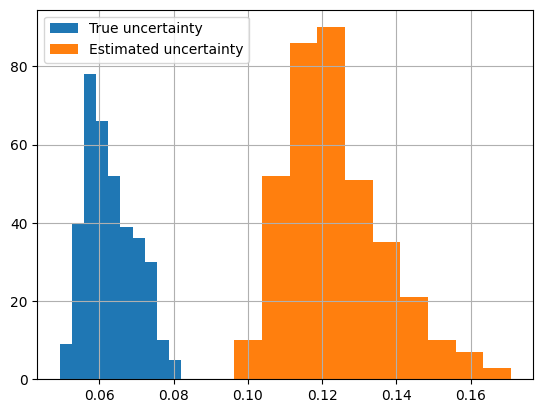

In [29]:
plt.hist(true_uncertainty, label = 'True uncertainty')
plt.hist(estimated_uncertainty,  label = 'Estimated uncertainty')
plt.legend()
plt.grid()
plt.show()

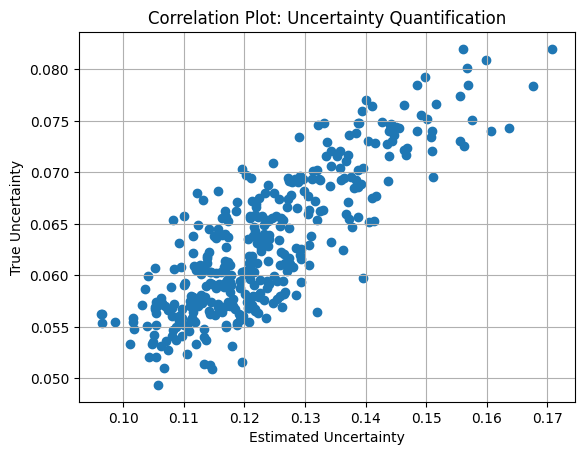

In [33]:
plt.scatter(estimated_uncertainty, true_uncertainty)
plt.xlabel('Estimated Uncertainty')
plt.ylabel('True Uncertainty')
plt.title('Correlation Plot: Uncertainty Quantification')
plt.grid()
plt.show()

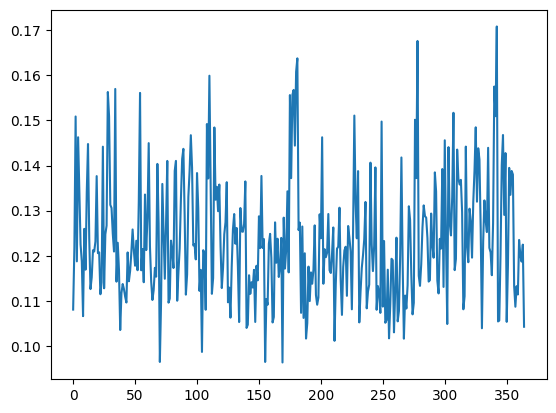

In [31]:
# Investigate uncertainty throughout time. Seasonal effect or vacations
plt.plot(estimated_uncertainty) # Prøv true uncertainty - sammenlign med estimated uncertainty.
# Not really

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

data_source = (
    "https://gist.githubusercontent.com/"
    "notionparallax/7ada7b733216001962dbaa789e246a67/raw/"
    "6d306b5d928b04a5a2395469694acdd8af3cbafb/example.csv"
)

df = (
    pd.read_csv(data_source, index_col=0)
    .assign(ed_name=lambda x: x["ed_name"].str.extract(r"(\d+)").astype(int))
    .value_counts(["ed_name", "source"])
    .groupby("ed_name")
    .rank("first", ascending=False)
    .rename("rank")
    .sort_index()
    .reset_index()
    .query("ed_name < 17")
)

In [6]:
df

,ed_name,source,rank
0,1,groene.nl,2.0
1,1,lithub,7.0
2,1,newyorker,1.0
3,1,thecut,6.0
4,1,theguardian,5.0
...,...,...,...
5135,16,wunderground,260.0
5136,16,www-psychologytoday-com.cdn.ampproject.org,261.0
5137,16,yogalondon.net,262.0
5138,16,zander.substack,263.0


In [10]:
top_sources = df[df["ed_name"] == df["ed_name"].max()].nsmallest(10, "rank")
top_sources

,ed_name,source,rank
4985,16,nytimes,1.0
5081,16,theguardian,2.0
4949,16,medium,3.0
4859,16,getpocket,4.0
5071,16,theatlantic,5.0
4976,16,newyorker,6.0
4874,16,hbr.org,7.0
4710,16,365tomorrows,8.0
5132,16,wired,9.0
5031,16,sciencefocus,10.0


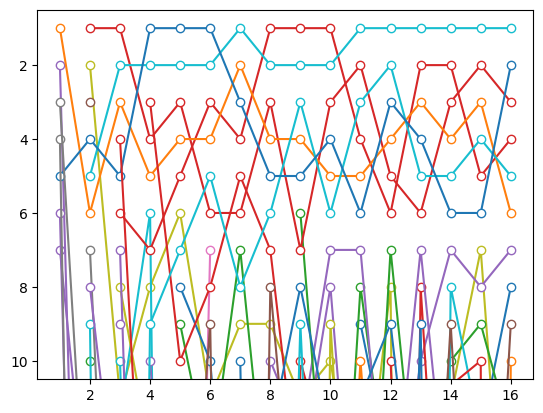

In [8]:
for i, j in df.groupby("source"):
    plt.plot("ed_name", "rank", "o-", data=j, mfc="w")
plt.ylim(0.5, 0.5 + 10)
plt.gca().invert_yaxis()